In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, TargetEncoder
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer

import statsmodels.api as sm

from warnings import simplefilter
simplefilter("ignore")

In [2]:
data = pd.read_csv('../regression/Walmart.csv')
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


### EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [4]:
data.isna().sum()
# Пропущенных значений в датасете нет

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

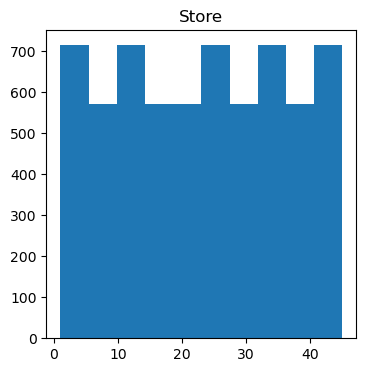

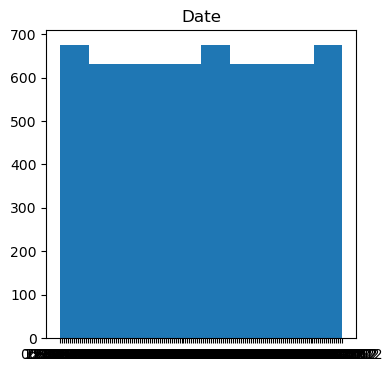

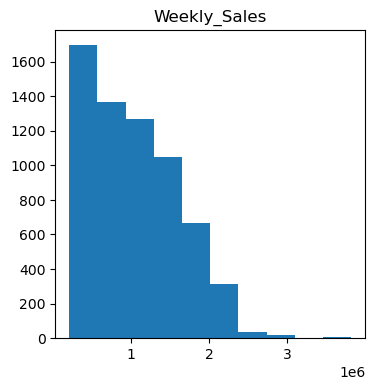

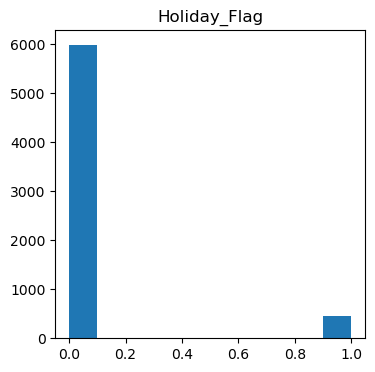

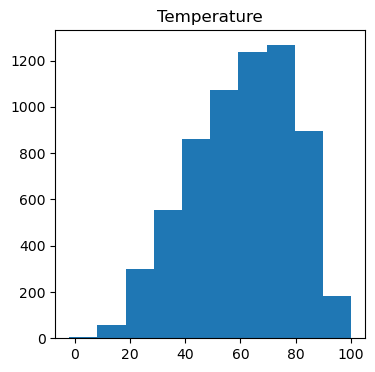

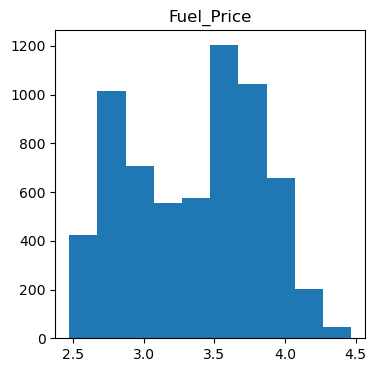

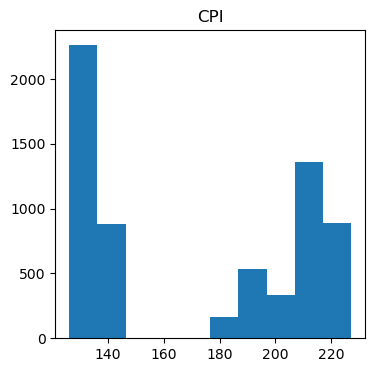

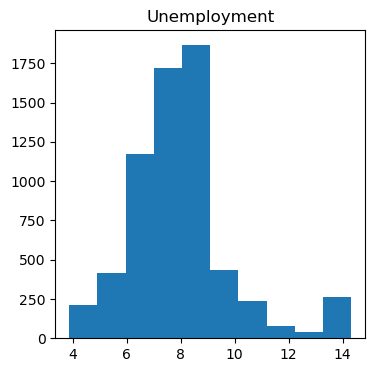

In [5]:
for col in data.columns:
    plt.figure(figsize=(4,4))
    plt.hist(data[col])
    plt.title(f'{col}')
    plt.show()

##### для повышения интерпретируемости изменим признак temperature в градусы Цельсия

In [6]:
def to_cels(x):
    return (x - 32) * 5 / 9

data['Temperature'] = data['Temperature'].apply(to_cels)

##### из стообца с данными о дате "извлечем" месяц, сформировав категориальный признак "Month"

In [7]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

data['Month'] = data['Date'].dt.month

data.drop('Date', axis=1, inplace=True)

##### Выведем признак "Season"

In [8]:
def get_season(x):
    
    if x in [1, 2, 12]:
        x = 'Winter'
        
    elif 3 <= x <= 5:
        x = 'Spring'
        
    elif 6 <= x <= 8:
        x = 'Summer'
        
    else:
        x = 'Autumn'
        
    return x

In [9]:
data['Season'] = data['Month'].apply(get_season)
data.drop('Month', axis=1, inplace=True)

### Preprocessing

##### Оценим границы распределения признаков для принятия решения о необходимости ограничения выбросов

In [10]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,15.924324,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,10.247185,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-18.922222,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,8.588889,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,17.038889,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,23.855556,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,37.855556,4.468000,227.232807,14.313000


##### Категориальный признак Season закодируем с помощью OneHotEncoding

In [11]:
def to_ohe(col):
    
    encoded = pd.get_dummies(data, columns=[col])
    
    return encoded

In [12]:
data = to_ohe('Season')

##### Ограничим признак Unemployment c помощью IQR

In [13]:
def cut_outliers_IQR(clmn, N=1.5):
    Q1 = clmn.quantile(0.25)
    Q3 = clmn.quantile(0.75)
    IQR = Q3 - Q1
    Lim_max = Q3 + IQR*N
    Lim_min = Q1 - IQR*N
    
    def cutting(x):
        if x > Lim_max:
            x = Lim_max
        elif x < Lim_min:
            x = Lim_min
        return x
    clmn_new = clmn.apply(cutting)
    return clmn_new

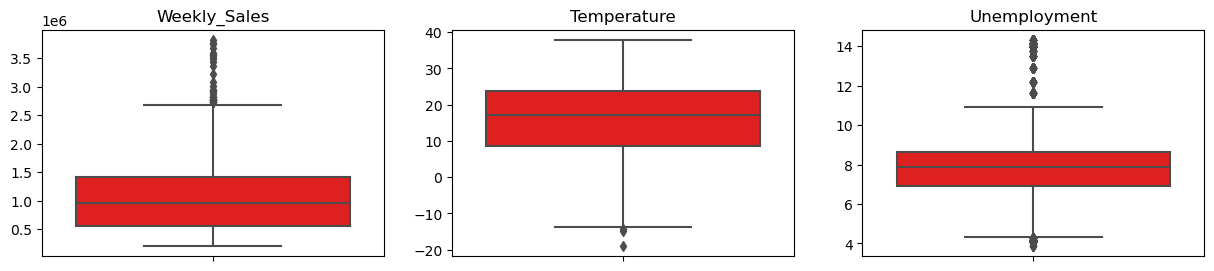

In [14]:
columns=['Weekly_Sales','Temperature','Unemployment']
plt.figure(figsize=(15,10))
colors = ['blue', 'red', 'purple']
for i,colum  in enumerate(columns,1):
    plt.subplot(3,3,i)
    sns.boxplot(data=data, y=colum,color='red')
    plt.xlabel('')  # Empty string removes the label
    plt.ylabel('') 
    plt.title(colum)

In [15]:
data['Unemployment'] = cut_outliers_IQR(data['Unemployment'])
data['Temperature'] = cut_outliers_IQR(data['Temperature'])
data['Weekly_Sales'] = cut_outliers_IQR(data['Weekly_Sales'])

##### Стандартизируем Weekly_Sales, Temperature, Fuel_Price, CPI и Unemployment для моделей, чувствительных к масштабу

In [16]:
to_stand = ['Unemployment', 'Fuel_Price', 'CPI', 'Temperature']
the_rest = []
for i in data.columns:
    if i not in to_stand:
        the_rest.append(i)

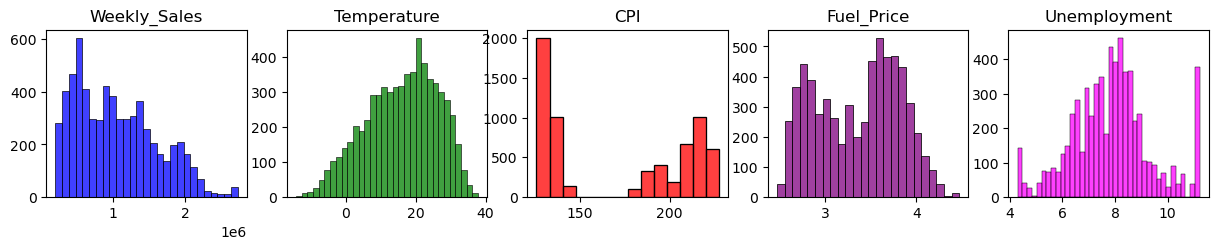

In [17]:
columns=['Weekly_Sales', 'Temperature', 'CPI','Fuel_Price','Unemployment']
plt.figure(figsize=(15,10))
colors = ['blue', 'green', 'red', 'purple','magenta']
for i,colum  in enumerate(columns,1):
    plt.subplot(4,5,i)
    sns.histplot(data[colum],color=colors[i-1])
    plt.title(colum)
    plt.xlabel('')  # Empty string removes the label
    plt.ylabel('')

##### Применим Transformer, чтобы распределение стало более похожим на нормальное

In [18]:
from sklearn.preprocessing import PowerTransformer

data_1 = data[to_stand].copy()
p_t = PowerTransformer(standardize=True)
data_tr = pd.DataFrame(p_t.fit_transform(data_1),columns=to_stand)
data_standard = pd.concat([data_tr, data[the_rest]], axis=1)
data_standard

,Unemployment,Fuel_Price,CPI,Temperature,Store,Weekly_Sales,Holiday_Flag,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,0.179767,-1.683544,1.006528,-1.008923,1,1643690.90,0,False,False,False,True
1,0.179767,-1.732738,1.009450,-1.211062,1,1641957.44,1,False,False,False,True
2,0.179767,-1.802251,1.010391,-1.135784,1,1611968.17,0,False,False,False,True
3,0.179767,-1.706104,1.011002,-0.776893,1,1409727.59,0,False,False,False,True
4,0.179767,-1.574543,1.011613,-0.783903,1,1554806.68,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
6430,0.552466,1.408278,0.604228,0.219329,45,713173.95,0,True,False,False,False
6431,0.541603,1.380942,0.607706,0.219880,45,733455.07,0,True,False,False,False
6432,0.541603,1.415115,0.611181,-0.351524,45,734464.36,0,True,False,False,False
6433,0.541603,1.344527,0.611260,-0.242318,45,718125.53,0,True,False,False,False


In [19]:
target = data_standard['Weekly_Sales'].copy()
data_standard.drop('Weekly_Sales', axis=1, inplace=True)
data_standard

,Unemployment,Fuel_Price,CPI,Temperature,Store,Holiday_Flag,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,0.179767,-1.683544,1.006528,-1.008923,1,0,False,False,False,True
1,0.179767,-1.732738,1.009450,-1.211062,1,1,False,False,False,True
2,0.179767,-1.802251,1.010391,-1.135784,1,0,False,False,False,True
3,0.179767,-1.706104,1.011002,-0.776893,1,0,False,False,False,True
4,0.179767,-1.574543,1.011613,-0.783903,1,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
6430,0.552466,1.408278,0.604228,0.219329,45,0,True,False,False,False
6431,0.541603,1.380942,0.607706,0.219880,45,0,True,False,False,False
6432,0.541603,1.415115,0.611181,-0.351524,45,0,True,False,False,False
6433,0.541603,1.344527,0.611260,-0.242318,45,0,True,False,False,False


plt.figure(figsize=(15,15))
sns.heatmap(data_standard.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()


In [20]:
x_train, x_test, y_train, y_test = train_test_split(data_standard, target, test_size=0.2, random_state=42)

##### Применим target encoding для работы с категориальной переменной store, которая в настоящее время закодирована с помощью label encoding, что неэффективно при большом количестве категорий

In [21]:
x_train

,Unemployment,Fuel_Price,CPI,Temperature,Store,Holiday_Flag,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
1033,-1.024373,-1.663016,1.081642,0.796856,8,0,True,False,False,False
915,0.637891,0.012702,0.605224,-2.100893,7,0,False,True,False,False
5903,0.755248,-0.511587,-1.196665,0.019073,42,0,True,False,False,False
2083,-0.016508,1.201500,-0.875108,0.457222,15,0,False,False,True,False
5943,0.277812,0.834115,-1.104482,1.469896,42,0,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
3772,-0.002703,0.117791,-0.842049,-1.168163,27,0,False,False,False,True
5191,0.419148,-1.402841,0.992064,-0.353161,37,0,False,False,False,True
5226,0.225929,0.702098,1.070191,1.431333,37,0,False,False,True,False
5390,2.113447,0.135341,-1.076482,-0.884027,38,1,False,False,False,True


In [23]:
encoder = TargetEncoder()
scaler = MinMaxScaler()

store_enc = encoder.fit_transform(x_train[['Store']], y_train)
store_train = scaler.fit_transform(store_enc)
x_train['Store'] = store_train

store_enc_test = encoder.transform(x_test[['Store']])
store_test = scaler.fit_transform(store_enc_test)
x_test['Store'] = store_test

### Linear Regression

In [24]:
Li_Reg = LinearRegression()
Li_Reg.fit(x_train, y_train)

pred = Li_Reg.predict(x_test)

mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

In [25]:
print(f'mse = {mse}', 
     f'mae = {mae}',
     f'r2 = {r2}', sep='\n')

mse = 20184013922.150295
mae = 89255.8238053613
r2 = 0.9353834644903606


In [ ]:
#!pip install statsmodels

In [ ]:
'''
для проверки на мультиколлинеарность 

def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)
    '''

### Lasso Regression

In [26]:
La_Reg = Lasso()
La_Reg.fit(x_train, y_train)

predi = La_Reg.predict(x_test)

print(mean_squared_error(y_test, predi))
print(mean_absolute_error(y_test, predi))
r2_score(y_test, predi)

20183860243.24458
89254.3258144894


0.9353839564736948

### Ridge Regression

In [28]:
Rid_Reg = Ridge()
Rid_Reg.fit(x_train, y_train)

predi = Rid_Reg.predict(x_test)

print(mean_squared_error(y_test, predi))
print(mean_absolute_error(y_test, predi))
r2_score(y_test, predi)

20160234352.545746
89138.78187516863


0.9354595917368875

### DecisionTreeRegressor

In [32]:
DTR = DecisionTreeRegressor()
DTR.fit(x_train, y_train)

predi = DTR.predict(x_test)

print(mean_squared_error(y_test, predi))
print(mean_absolute_error(y_test, predi))
r2_score(y_test, predi)

28696528073.490433
90440.82571289821


0.908131740672793

### Random Forest Regressor

In [33]:
RFR = RandomForestRegressor()
RFR.fit(x_train, y_train)

predi = RFR.predict(x_test)

print(mean_squared_error(y_test, predi))
print(mean_absolute_error(y_test, predi))
r2_score(y_test, predi)

14069303778.045591
67999.80063820902


0.9549589258768636

### XGboostRegressor

In [34]:
XBBR = XGBRegressor()
XBBR.fit(x_train, y_train)

predi = XBBR.predict(x_test)

print(mean_squared_error(y_test, predi))
print(mean_absolute_error(y_test, predi))
r2_score(y_test, predi)

10523556391.957695
60697.664727078474


0.9663101820127864